<a href="https://colab.research.google.com/github/Nelson-iitp/2121CS07_CS575/blob/main/CS575_MidSem/2121CS07_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import  ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.signal import convolve
import statsmodels.tsa as tsa

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Load

In [ ]:
DS_PATH = [
 "https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset1_global_mean_temp.csv",
 "https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset2_month_temp.csv",
 "https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset3_nasdaq_1985_2014.csv",
 "https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset4_yahoo304.96.8.14.csv",
 "https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset5_yearssn.csv",
 "https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset6_ftse.csv"
          ]
DSA = []
data_LA = []
for p in DS_PATH:
  DSA.append(np.loadtxt(p)) 
  print('\nLoad@', p)
  print(len(DSA[-1]),DSA[-1].dtype)
  data_LA.append( int(len(DSA[-1])/2)) #<----- by default 1/2 of total count
DSnos = len(DSA)
print('\n#'+str(DSnos),data_LA)


Load@ https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset1_global_mean_temp.csv
134 float64

Load@ https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset2_month_temp.csv
223 float64

Load@ https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset3_nasdaq_1985_2014.csv
7276 float64

Load@ https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset4_yahoo304.96.8.14.csv
4613 float64

Load@ https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset5_yearssn.csv
314 float64

Load@ https://raw.githubusercontent.com/cs575ts/Assignments/main/CS575_MidSem/Dataset/Dataset6_ftse.csv
141 float64

#6 [67, 111, 3638, 2306, 157, 70]


# Question


For each of the dataset you need to do the following tasks:

[ 01 ] Compute the KPSS and ADF test and comment on the stationariety of the Dataset. If its not stationery, then make it stationery by differencing or other methods.
	
[ 02 ] Appply the following algorithms
1. Single, double and triple Exponential Smoothing for all the three datasets as provided. Do not use the built in libraries, use the ones you developed for the previous assignment.
2. Only AR
3. Only MA
4. ARIMA
5. SARIMA (if the data has seasonality)

There is an excel file provided "Make Such a Table for every Dataset in Jupyter", make such a table in the ipynb notebook
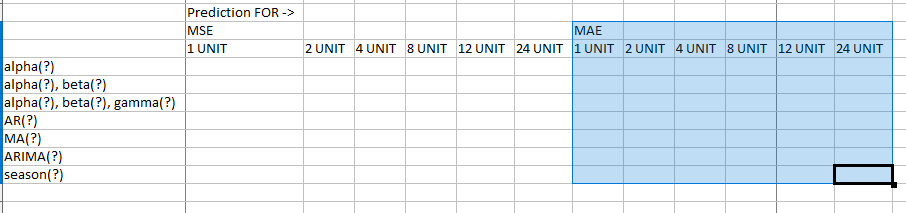


The dataset does not have time column, so you can assume a serialized time from 1 to n. (1 unit .. to n unit)

You can choose and try different values of alpha, beta, gamma and provide those values of alpha, beta, gamma for which the MSE for the least. Similarly for AR/MA/ARIMA models, try out different combinations and mention the optimal one. You can use auto-arima.
Plot the MSE for the constructed table.


# Solution

##[ 01 ] KPSS, ADF Test 

In [ ]:
# define adf and kpss testing

def adf_test(ds, p_threshold , details = False):
  res=""
  res += '\nADF-Test Hypothesis :: Series is Non-Stationary\n'
  timeseries = ds.dropna()
  dftest = adfuller(timeseries,  regression='c', autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] =  (value, getHres(dftest[0],value) )

  if details:
    res+=str(dfoutput)+"\n"

  #if dftest[1]<p_threshold: # hypothesis is false = Rejected
  #if dftest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (dftest[1]>=p_threshold)
  res+= "RESULT :: Hypothesis is "+str( resb )
  
  return res, resb, dftest[1]

def kpss_test(ds, p_threshold , details = False):
  res=""
  res += '\nKPSS-Test Hypothesis :: Series is Trend-Stationary\n'
  timeseries = ds.dropna()
  kpsstest = kpss(timeseries, regression='ct')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] =  (value, getHres(value,kpsstest[0]) )
  
  if details:
    res+=str(kpss_output)+"\n"

  #if kpsstest[1]<p_threshold: # hypothesis is false = Rejected
  #if kpsstest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (kpsstest[1]>=p_threshold)
  res+= "RESULT :: Hypothesis is "+str( resb )
  return res, resb, kpsstest[1]

def getHres(test_stat, crit_val):
  if test_stat<crit_val:
    return "Hypothesis: False"
  else:
    return "Hypothesis: True"
   

##[ 01 ] Converting to Stationary Series

In [ ]:
# differencing
def c2s_differencing(Y, season):
  res = np.zeros(len(Y))
  res[season:] = Y[season:] - Y[0:-season]
  return res

#Y[t] = Y[t]-Y[t-1]
#Y[t] = Y[t]-Y[t-7] #<<--seasonal

# transformation
# take log, root ...etc using numpy 
# - use with differencing - first transform then take difference

# rolling stats
# take moving average of window 10
def c2s_movingAvg(Y, win):
  return convolve(Y, np.ones(win)/win,'same')

### Start testing...


DATASET # 1
-----------------------------------------------------------------------


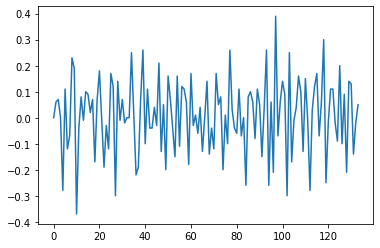

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -11.3423
p-value                                                     1.04745e-20
#Lags Used                                                            2
Number of Observations Used                                         131
Critical Value (1%)             (-3.481281802271349, Hypothesis: False)
Critical Value (5%)             (-2.883867891664528, Hypothesis: False)
Critical Value (10%)           (-2.5786771965503177, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0605452
p-value                                        0.1
Lags Used                                       13
Critical Value (10%)     (0.119, Hypothesis: True)
Cri

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


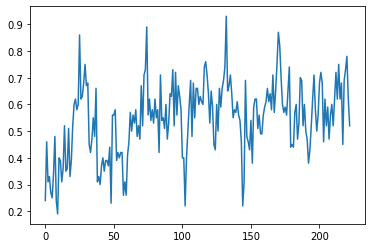

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                -4.04491
p-value                                                     0.00119276
#Lags Used                                                           3
Number of Observations Used                                        219
Critical Value (1%)            (-3.460567372610299, Hypothesis: False)
Critical Value (5%)            (-2.874829809033386, Hypothesis: False)
Critical Value (10%)           (-2.573853225954421, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0939509
p-value                                        0.1
Lags Used                                       15
Critical Value (10%)     (0.119, Hypothesis: True)
Critical V

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


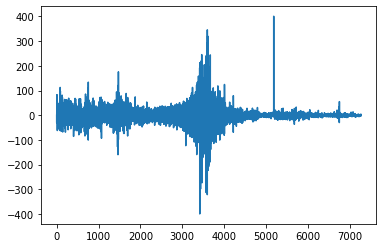

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -13.0476
p-value                                                      2.1758e-24
#Lags Used                                                           36
Number of Observations Used                                        7239
Critical Value (1%)             (-3.431253663537004, Hypothesis: False)
Critical Value (5%)            (-2.8619393487569407, Hypothesis: False)
Critical Value (10%)            (-2.566982569144498, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0780858
p-value                                        0.1
Lags Used                                       36
Critical Value (10%)     (0.119, Hypothesis: True)
Cri

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


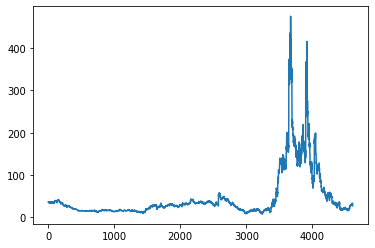

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -3.28673
p-value                                                        0.015482
#Lags Used                                                           30
Number of Observations Used                                        4582
Critical Value (1%)              (-3.431777971900744, Hypothesis: True)
Critical Value (5%)            (-2.8621709964988606, Hypothesis: False)
Critical Value (10%)           (-2.5671058823769246, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                             0.549547
p-value                                        0.01
Lags Used                                        32
Critical Value (10%)     (0.119, Hypothesis: False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


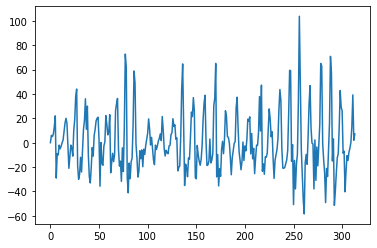

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -14.9846
p-value                                                     1.14893e-27
#Lags Used                                                            7
Number of Observations Used                                         306
Critical Value (1%)            (-3.4519023023726696, Hypothesis: False)
Critical Value (5%)            (-2.8710320399170537, Hypothesis: False)
Critical Value (10%)             (-2.57182745012602, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0218836
p-value                                        0.1
Lags Used                                       16
Critical Value (10%)     (0.119, Hypothesis: True)
Cri

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


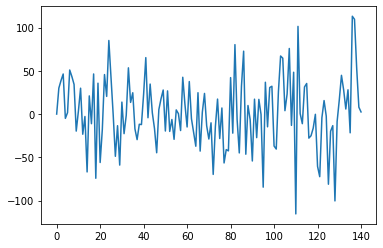

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -11.2567
p-value                                                     1.66042e-20
#Lags Used                                                            0
Number of Observations Used                                         140
Critical Value (1%)            (-3.4779446621720114, Hypothesis: False)
Critical Value (5%)            (-2.8824156122448983, Hypothesis: False)
Critical Value (10%)            (-2.577901887755102, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0870866
p-value                                        0.1
Lags Used                                       14
Critical Value (10%)     (0.119, Hypothesis: True)
Cri

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
thresh, show_details =  0.05, True #<---------- set pvalue threshold here
adf0_res = []
kps0_res = []

for i in range (0,DSnos):
  
  print ("\nDATASET #", i+1)
  data = pd.Series( ( DSA[i]))
  print("-----------------------------------------------------------------------")

  plt.plot(data)
  plt.show()
  print("-----------------------------------------------------------------------")

  tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
  print(tRes)
  adf0_res.append([bRes,pRes])
  print("-----------------------------------------------------------------------")

  tRes, bRes, pRes = kpss_test(data,thresh,details=show_details)
  print(tRes)
  kps0_res.append([bRes,pRes])
  print("-----------------------------------------------------------------------")
  print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

adf0_res = np.array(adf0_res)
kps0_res = np.array(kps0_res)
#print('\nRES_ADF:',adf0_res,'\nRES_KPS:',kps0_res)

### Find Non-Stationary Series

In [ ]:
# find all array where adf is true (=1) adf0_res / kps0_res
dsi = np.where(adf0_res[:,0]==1)[0]
print(dsi)

[]


### Differencing

Convert to stationary-----------------------------

DATASET # 1

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -11.3423
p-value                                                     1.04745e-20
#Lags Used                                                            2
Number of Observations Used                                         131
Critical Value (1%)             (-3.481281802271349, Hypothesis: False)
Critical Value (5%)             (-2.883867891664528, Hypothesis: False)
Critical Value (10%)           (-2.5786771965503177, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False


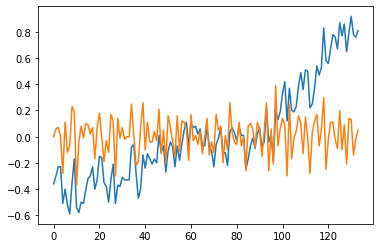

Replace Dataset # 0


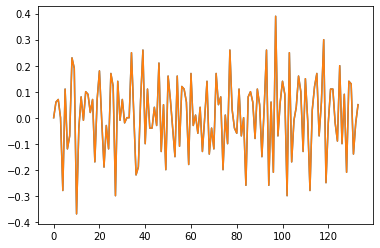


DATASET # 3

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -13.0476
p-value                                                      2.1758e-24
#Lags Used                                                           36
Number of Observations Used                                        7239
Critical Value (1%)             (-3.431253663537004, Hypothesis: False)
Critical Value (5%)            (-2.8619393487569407, Hypothesis: False)
Critical Value (10%)            (-2.566982569144498, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False


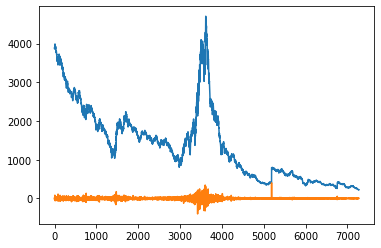

Replace Dataset # 2


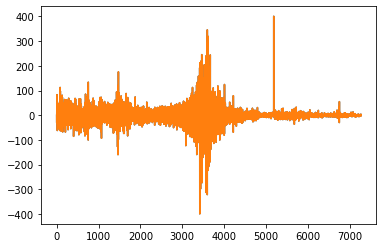


DATASET # 5

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -14.9846
p-value                                                     1.14893e-27
#Lags Used                                                            7
Number of Observations Used                                         306
Critical Value (1%)            (-3.4519023023726696, Hypothesis: False)
Critical Value (5%)            (-2.8710320399170537, Hypothesis: False)
Critical Value (10%)             (-2.57182745012602, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False


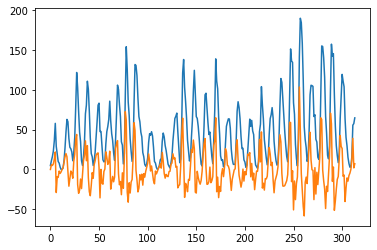

Replace Dataset # 4


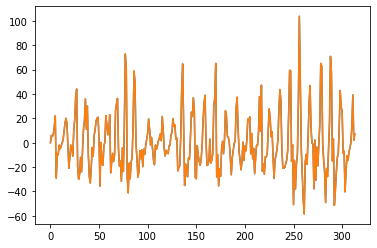


DATASET # 6

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -11.2567
p-value                                                     1.66042e-20
#Lags Used                                                            0
Number of Observations Used                                         140
Critical Value (1%)            (-3.4779446621720114, Hypothesis: False)
Critical Value (5%)            (-2.8824156122448983, Hypothesis: False)
Critical Value (10%)            (-2.577901887755102, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False


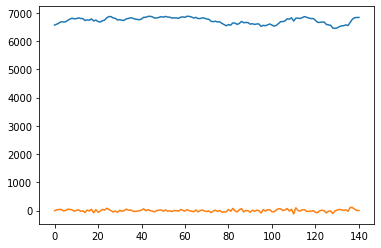

Replace Dataset # 5


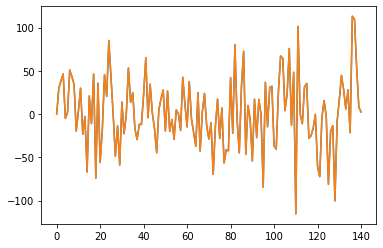

In [ ]:
print('Convert to stationary-----------------------------')

#1 - try c2s_differencing
for i in dsi:
  
  print ("\nDATASET #", i+1)

  DSft = c2s_differencing( DSA[i],1)


  data = pd.Series( DSft)
  tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
  print(tRes)
  plt.plot(DSA[i])
  plt.plot(DSft)
  plt.show()

  if not bRes:
    DSA[i]=DSft   #<<------- REPLACE DATA
    print ('Replace Dataset #',i)
    plt.plot(DSA[i])
    plt.plot(DSft)
    plt.show() 


### Moving Average

Convert to stationary-----------------------------

DATASET # 1

ADF-Test Hypothesis :: Series is Non-Stationary
RESULT :: Hypothesis is True


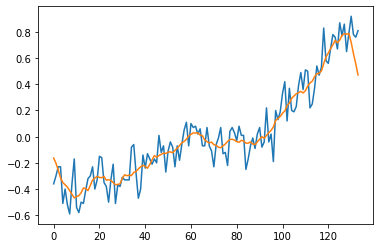


DATASET # 3

ADF-Test Hypothesis :: Series is Non-Stationary
RESULT :: Hypothesis is True


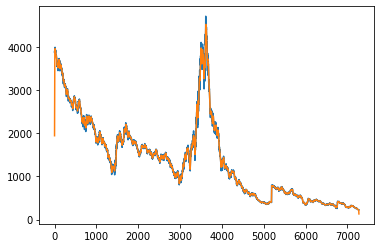


DATASET # 5

ADF-Test Hypothesis :: Series is Non-Stationary
RESULT :: Hypothesis is False


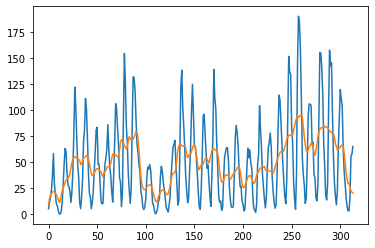


DATASET # 6

ADF-Test Hypothesis :: Series is Non-Stationary
RESULT :: Hypothesis is True


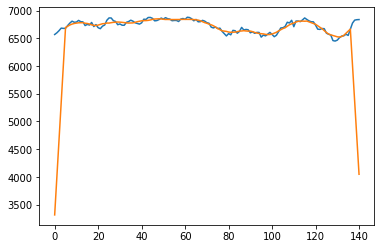

In [ ]:
print('Convert to stationary-----------------------------')

#1 - try c2s_movingAvg
for i in dsi:
  
  print ("\nDATASET #", i+1)
  DSft = c2s_movingAvg( DSA[i],10) 
  data = pd.Series(DSft  )
  tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
  print(tRes)
  if not bRes:
    DSA[i]=DSft   #<<------- REPLACE DATA
    print ('Replace Dataset #',i)
    plt.plot(DSA[i])
    plt.plot(DSft)
    plt.show() 

 

### log Transform + differencing

Convert to stationary-----------------------------

DATASET # 1

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -11.3423
p-value                                                     1.04745e-20
#Lags Used                                                            2
Number of Observations Used                                         131
Critical Value (1%)             (-3.481281802271349, Hypothesis: False)
Critical Value (5%)             (-2.883867891664528, Hypothesis: False)
Critical Value (10%)           (-2.5786771965503177, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
Replace Dataset # 0


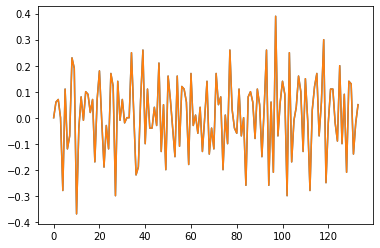


DATASET # 3

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -13.0476
p-value                                                      2.1758e-24
#Lags Used                                                           36
Number of Observations Used                                        7239
Critical Value (1%)             (-3.431253663537004, Hypothesis: False)
Critical Value (5%)            (-2.8619393487569407, Hypothesis: False)
Critical Value (10%)            (-2.566982569144498, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
Replace Dataset # 2


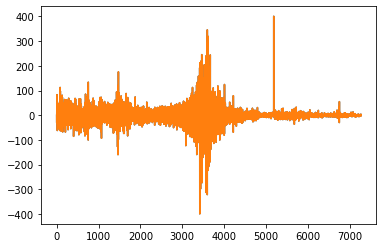


DATASET # 5

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -14.9846
p-value                                                     1.14893e-27
#Lags Used                                                            7
Number of Observations Used                                         306
Critical Value (1%)            (-3.4519023023726696, Hypothesis: False)
Critical Value (5%)            (-2.8710320399170537, Hypothesis: False)
Critical Value (10%)             (-2.57182745012602, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
Replace Dataset # 4


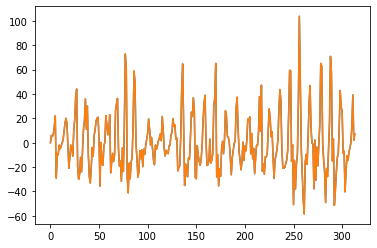


DATASET # 6

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -11.2567
p-value                                                     1.66042e-20
#Lags Used                                                            0
Number of Observations Used                                         140
Critical Value (1%)            (-3.4779446621720114, Hypothesis: False)
Critical Value (5%)            (-2.8824156122448983, Hypothesis: False)
Critical Value (10%)            (-2.577901887755102, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
Replace Dataset # 5


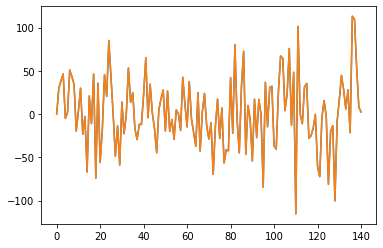

In [ ]:
print('Convert to stationary-----------------------------')

#1 - try Transform
for i in dsi:
  
  print ("\nDATASET #", i+1)
  DSft = np.copy(DSA[i])
  DSft -= np.min(DSft)
  #r0,r1 = np.min(DSft),np.max(DSft)
  DSft = c2s_differencing(DSft,1)
  data = pd.Series( (  DSft   ))
  tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
  print(tRes)

  if not bRes:
    DSA[i]=DSft   #<<------- REPLACE DATA
    print ('Replace Dataset #',i)
    plt.plot(DSA[i])
    plt.plot(DSft)
    plt.show() 


## [ 02 ] Apply Forecasting

In [ ]:
# define Results Table
intervals = [1,2,4,8,12,24]
# result table is 3d array
Result_Tabel = np.zeros((0,len(intervals),2))
Result_Ids = []
DataSet_Ids = []

def _temp_routine01(es_data,cast, my_id, my_ds):
  global Result_Tabel, Result_Ids
  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()


  itemp = np.zeros((1,len(intervals),2))
  for ig in range(0, len(intervals)):
    i = intervals[ig]    # ?may take a random location of interval = i
    itemp[0,ig,0] = np.sum((es_data.y[1:i+2] - cast[1:i+2])**2)/i 
    itemp[0,ig,1] = np.sum(np.abs(es_data.y[1:i+2] - cast[1:i+2]))/i 
    #print('Interval =',i,'MSE =', imse,'MAE =', imae)
  Result_Tabel = np.vstack((Result_Tabel,itemp))
  Result_Ids.append(my_id)
  DataSet_Ids.append(my_ds)

def _temp_routine02(es_data,cast, my_id, my_ds, append_result = True):
  global Result_Tabel, Result_Ids
  plt.figure(figsize=(12,6))
  plt.plot(es_data, linewidth="0.8", label="Data", color="black")
  plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()

  if append_result:
    itemp = np.zeros((1,len(intervals),2))
    for ig in range(0, len(intervals)):
      i = intervals[ig]    # ?may take a random location of interval = i
      itemp[0,ig,0] = np.sum((es_data[1:i+2] - cast[1:i+2])**2)/i 
      itemp[0,ig,1] = np.sum(np.abs(es_data[1:i+2] - cast[1:i+2]))/i 
      #print('Interval =',i,'MSE =', imse,'MAE =', imae)
    Result_Tabel = np.vstack((Result_Tabel,itemp))
    Result_Ids.append(my_id)
    DataSet_Ids.append(my_ds)

  

### [1] Exponential Smoothing

In [ ]:
class ExpSmoothingData:
  def __init__(self, y):
    # L = periods in a season, at most half of total duration - so that b(t) can be initialized
    self.y = y
    self.N = len(y)
    #print(type(self.y),type(self.N),self.N)

#~~~ SINGLE 0~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Single_ES(self, a):
    N,y=self.N,self.y
    self.S = np.zeros(N,dtype='float')        #Smoothed Value  ::'0th element is invalid'
    S=self.S
    # initialization 
    S[0] = y[0] 
    # Find Smoothed values
    for t in range(1, N):
      S[t] = a*y[t] + (1-a)*S[t-1]

    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S
#~~~ DOUBLE 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Double_ES(self, a, b): 
  # orignal Double ES
    N,y=self.N,self.y
    self.S = np.zeros(N).astype('float')        #Smoothed Value  ::'0th element is invalid'
    self.B = np.zeros(N).astype('float')          #b(t)
    B,S = self.B,self.S

    # initialization 
    S[0],B[0] = y[0], y[1] - y[0]

    # Find Smoothed values
    for t in range(1, N):
      S[t] = a*y[t] + (1-a)*(S[t-1]+B[t-1]) #<--- 1
      B[t] = b*(S[t]-S[t-1]) + (1-b)*B[t-1]

    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S

  def Do_Forecast_2(self, t, m):
    N,y=self.N,self.y
    S,B=self.S,self.B

    res = np.zeros(m)
    for i in range(1,m+1):
      res[i-1]=(S[t]+i*B[t])
    #res = (S[t]+m*B[t])#*I[t-L+m]

    return res
#~~~ TRIPLE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Triple_ES(self, a, b, g, L):
    N,y=self.N,self.y
    # inits
    self.TS = (N/L)                   #total seasons
    self.S = np.zeros(N).astype('float')        #Smoothed Value  ::'0th element is invalid'
    self.B = np.zeros(N).astype('float')          #b(t)
    self.I = np.zeros(N).astype('float')          #I(t) seasoal 
    
    TS,B,S,I = self.TS,self.B,self.S,self.I

    # initialization 
    S[0], B[0] = y[0], 0

    # Intial Trend Factor
    for i in range(0,L):
      B[0]+=y[L+i]-y[i]
    B[0]/=(L**2)
    

    # Initial Seasonal Indices
    aN = N - ( N % L ) #<<---makes it perfextly divisible
    yy = np.copy(y[0:aN]).reshape(int(TS),L).astype('float')
    for i in range(0, int(TS)):
      #print(np.average(yy[i,:]))
      #print('iseasonalX:',(np.average(yy[i,:]) ))
      yy[i,:] = yy[i,:]/(np.average(yy[i,:])) 
      
    for i in range(0,L):
      I[i] = np.average(yy[:,i])
      #print('iseasonal_:',I[i] )
      #only first L values available (0 to L-1)

    # Find Smoothed values
    for t in range(1, N):
      Ival = None
      if t<L:
        Ival=I[t]
      else:
        Ival=I[t-L]

      S[t] = a*(y[t]/Ival)+(1-a)*(S[t-1]+B[t-1]) #<<---2
      B[t] = b*(S[t]-S[t-1]) + (1-b)*B[t-1]

      #read i's from init values if not available
      if t>=L:
        I[t] = g*(y[t]/S[t]) + (1-g)*Ival
      
    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S

  def Do_Forecast_3(self, t, m,L):
    N,y=self.N,self.y
    S,B,I=self.S,self.B,self.I

    res = np.zeros(m)
    for i in range(1,m+1):
      res[i-1]=(S[t]+i*B[t])*I[(t-L+1+m-1)%L]
    #res = (S[t]+m*B[t])#*I[t-L+m]
    return res

#### [a] Single

alpha = 0.8

Dataset: 1 	MSE = 0.0017176381218328748


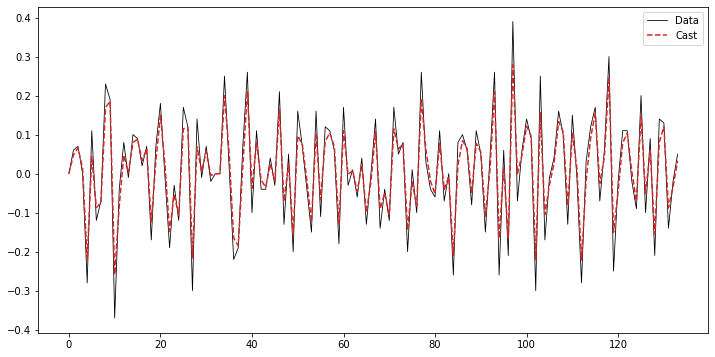


Done

Dataset: 2 	MSE = 0.0005169502983731942


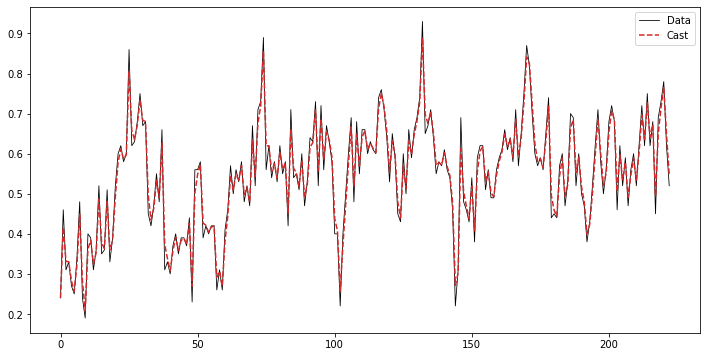


Done

Dataset: 3 	MSE = 77.83700596059948


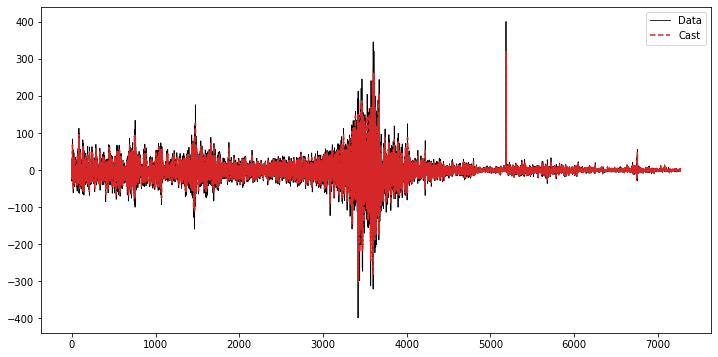


Done

Dataset: 4 	MSE = 1.4509936564522425


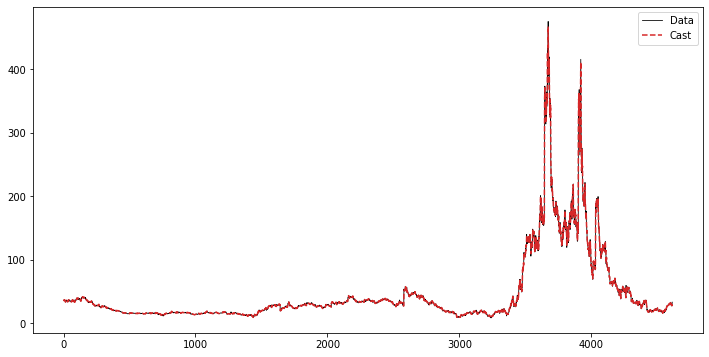


Done

Dataset: 5 	MSE = 21.34858975793


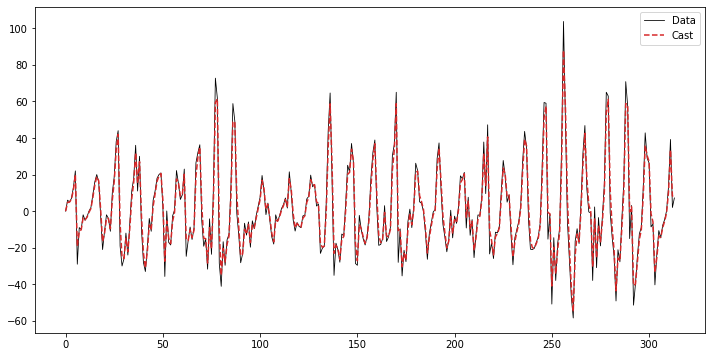


Done

Dataset: 6 	MSE = 102.99070835412391


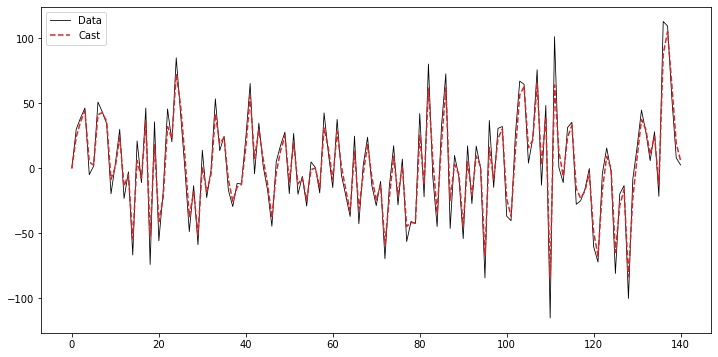


Done


In [ ]:
alpha = 0.8
print('alpha =',alpha)
for this_ds in range(0, DSnos):

  
  es_data = ExpSmoothingData(DSA[this_ds]) # orignal data
  mse,cast = es_data.Do_Single_ES(alpha)
  print('\nDataset:', this_ds+1,'\tMSE =',mse)
  _temp_routine01(es_data,cast,"SXS["+str(alpha)+",_._,_._]", this_ds+1)
  print("\nDone")


#### [b] Double

alpha = 0.5
beta = 0.5

Dataset: 1 	MSE = 0.010750745075603725


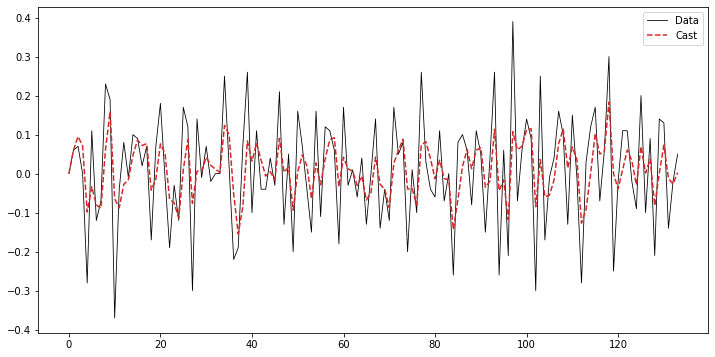


Dataset: 2 	MSE = 0.0042546595109728665


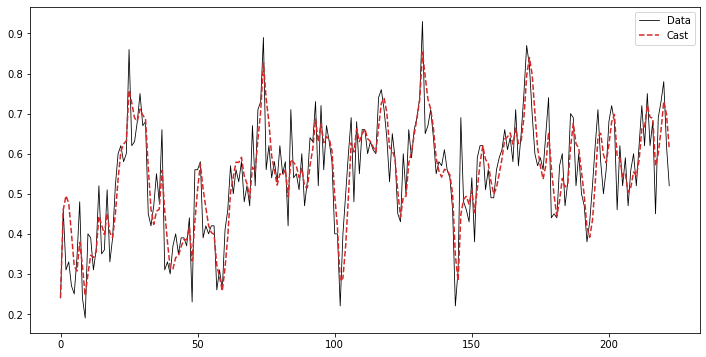


Dataset: 3 	MSE = 523.6742420921039


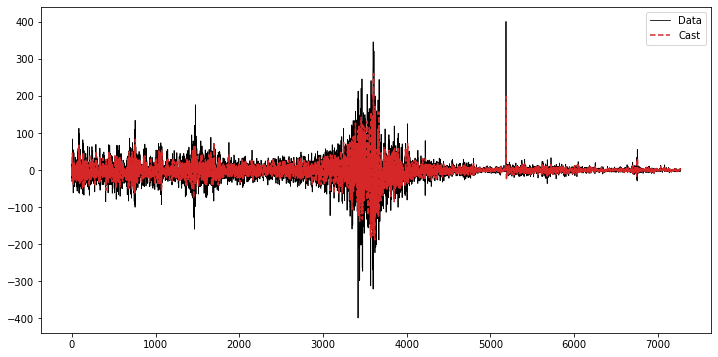


Dataset: 4 	MSE = 13.411424114251755


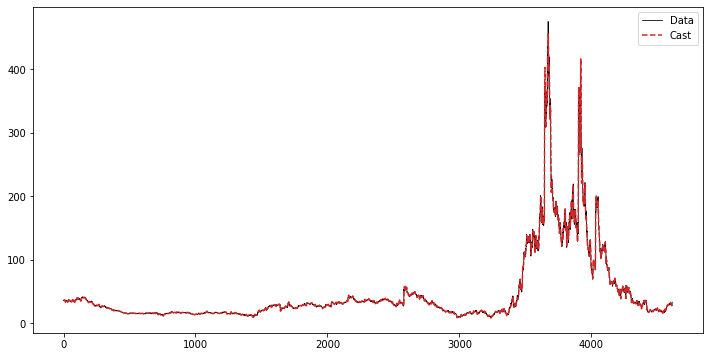


Dataset: 5 	MSE = 245.80746147019607


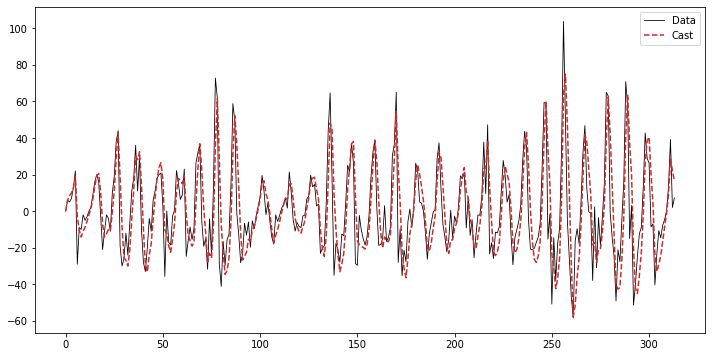


Dataset: 6 	MSE = 702.6149842130056


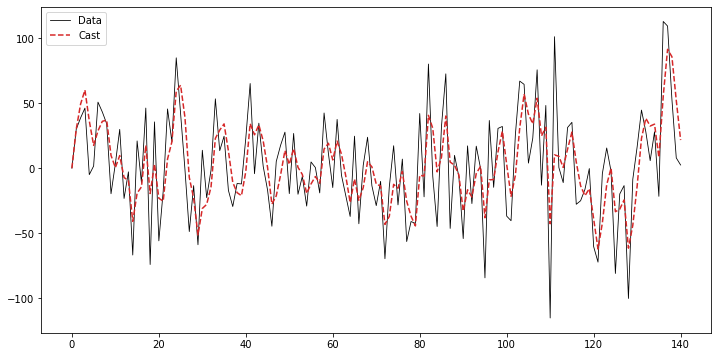

In [ ]:
alpha,beta = 0.5, 0.5
print('alpha =',alpha)
print('beta =',beta)
for this_ds in range(0, DSnos):
 
  es_data = ExpSmoothingData(DSA[this_ds]) # orignal data
  mse,cast = es_data.Do_Double_ES(alpha,beta)
  print('\nDataset:', this_ds+1,'\tMSE =',mse)
  _temp_routine01(es_data,cast,"DXS["+str(alpha)+","+str(beta)+",_._]", this_ds+1)

#### [c] Triple

alpha = 0.7
beta = 0.2
gamma = 0.3

Dataset: 1 	MSE = 0.12230620260981126


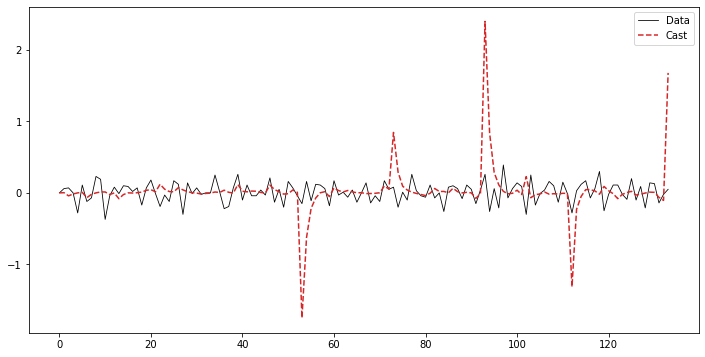


Dataset: 2 	MSE = 0.007932207550639466


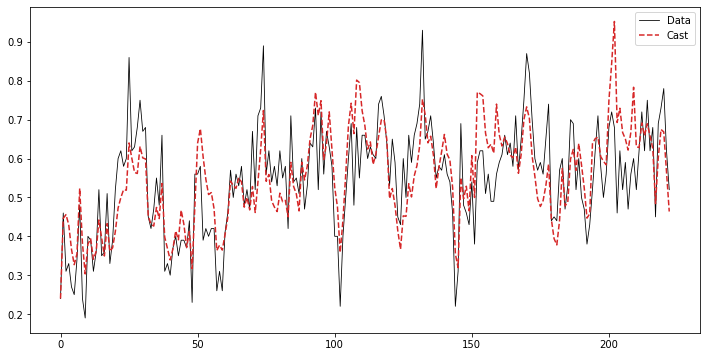


Dataset: 3 	MSE = 1114.8238559035537


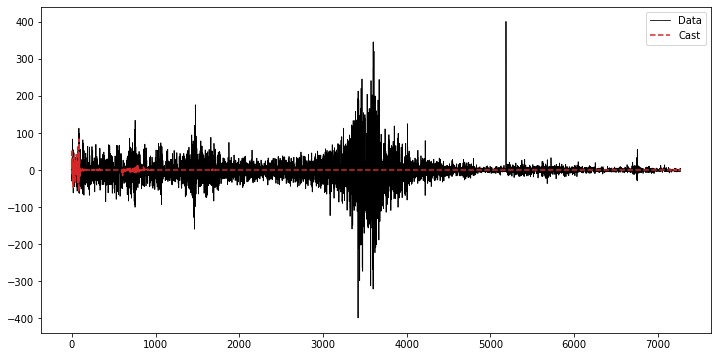


Dataset: 4 	MSE = 13.624204305314572


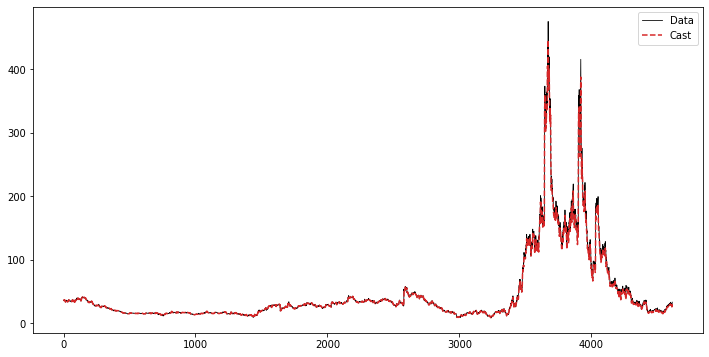


Dataset: 5 	MSE = 15718.552037988728


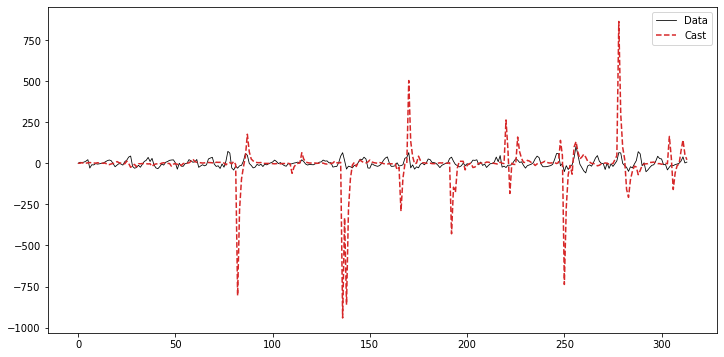


Dataset: 6 	MSE = 1768.2253337223467


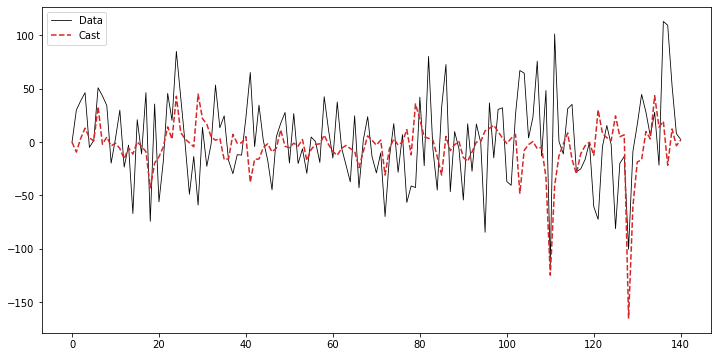

In [ ]:
data_LA = [20,50,2,2,28, 6]
alpha,beta,gamma = 0.7, 0.2, 0.3
print('alpha =',alpha)
print('beta =',beta)
print('gamma =',gamma)
for this_ds in range(0, DSnos):
 
  es_data = ExpSmoothingData(DSA[this_ds]) # orignal data
  mse,cast = es_data.Do_Triple_ES(alpha,beta,gamma ,data_LA[this_ds])
  print('\nDataset:', this_ds+1,'\tMSE =',mse)
  _temp_routine01(es_data,cast,"TXS["+str(alpha)+","+str(beta)+","+str(gamma)+"]", this_ds+1)


### [2] Pure AR

Model as ARMA with : 
AR-Order = 3
MA-Order = 0

Dataset#	 1
MSE		 2.0130200200157544
all-param	 [ 0.00863612 -0.48706067 -0.38940075 -0.30495152]
ar-param	 [-0.48706067 -0.38940075 -0.30495152]
ma-param	 []


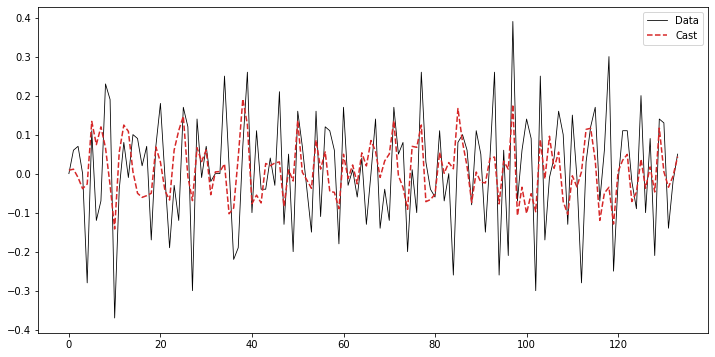


Dataset#	 2
MSE		 2.5253428724231703
all-param	 [ 0.5414999   0.46678863  0.24517843 -0.00669301]
ar-param	 [ 0.46678863  0.24517843 -0.00669301]
ma-param	 []


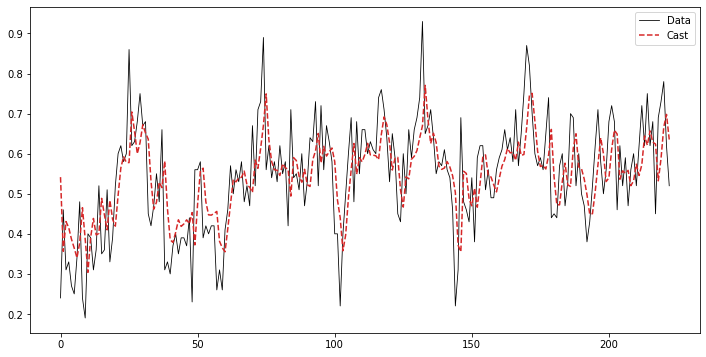


Dataset#	 3
MSE		 7971286.634532835
all-param	 [-0.50340416 -0.06423383 -0.0639862  -0.0218673 ]
ar-param	 [-0.06423383 -0.0639862  -0.0218673 ]
ma-param	 []


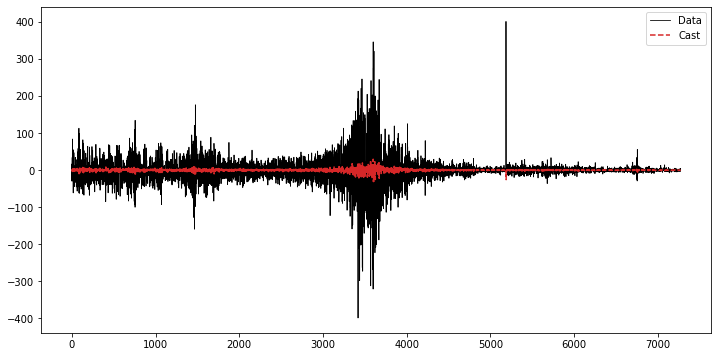


Dataset#	 4
MSE		 156340.71625241352
all-param	 [ 4.53650885e+01  1.05008856e+00 -3.96136209e-02 -1.60672309e-02]
ar-param	 [ 1.05008856 -0.03961362 -0.01606723]
ma-param	 []


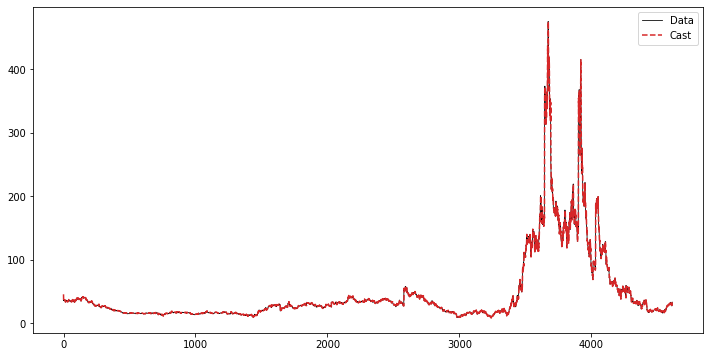


Dataset#	 5
MSE		 106362.55845255259
all-param	 [ 0.12507996  0.58490631 -0.01013385 -0.3336266 ]
ar-param	 [ 0.58490631 -0.01013385 -0.3336266 ]
ma-param	 []


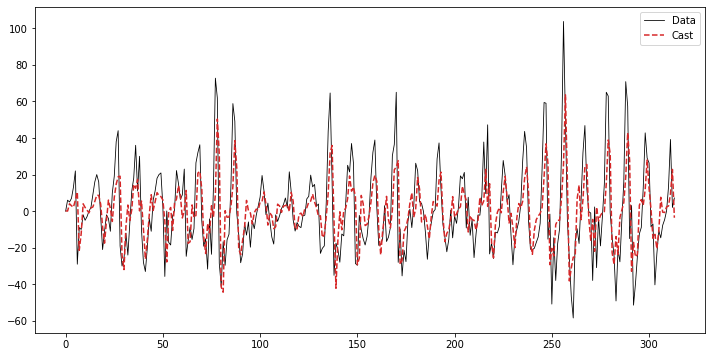


Dataset#	 6
MSE		 224712.26254798268
all-param	 [ 1.93131561  0.03857735  0.12280456 -0.01203463]
ar-param	 [ 0.03857735  0.12280456 -0.01203463]
ma-param	 []


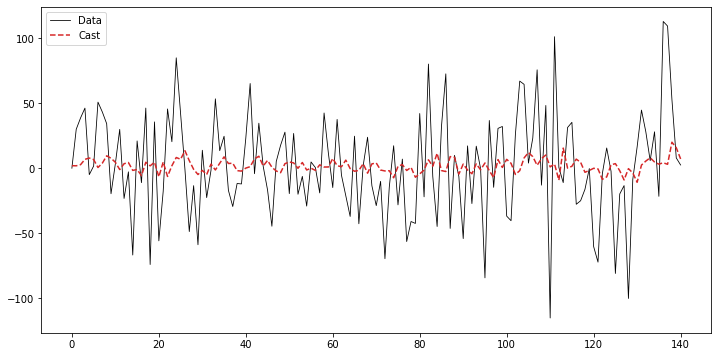

In [ ]:
morder_p =3
morder_q =0
print('Model as ARMA with : ')
print('AR-Order =',morder_p)
print('MA-Order =',morder_q)

for this_ds in range(0, DSnos):
  
  es_data = DSA[this_ds] # orignal data
  model = tsa.arima_model.ARMA(es_data,order=(morder_p,morder_q))
  result = model.fit()
  cast = result.predict(  )
  print('\nDataset#\t', this_ds+1)
  print('MSE\t\t',np.sum((es_data-cast)**2) )
  print('all-param\t',result.params)
  print('ar-param\t',result.arparams)
  print('ma-param\t',result.maparams)

  _temp_routine02(es_data,cast,"AR-"+ str(morder_p) + str(result.params), this_ds+1)


### [3] Pure MA

Model as ARMA with : 
AR-Order = 0
MA-Order = 3

Dataset#	 1
MSE		 1.9887440802852074
all-param	 [ 0.00895691 -0.54943254 -0.16966277 -0.00764249]
ar-param	 []
ma-param	 [-0.54943254 -0.16966277 -0.00764249]


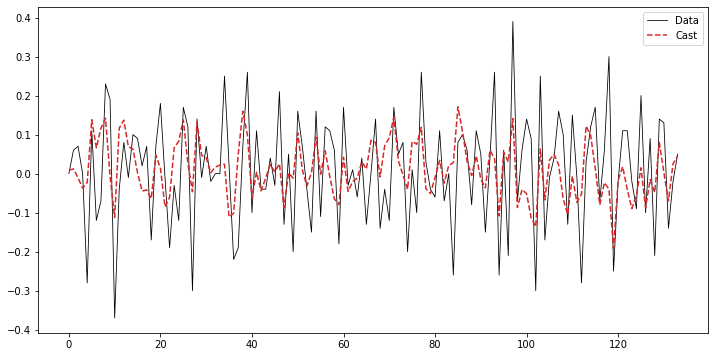


Dataset#	 2
MSE		 2.7205204964203773
all-param	 [0.54355995 0.51215733 0.3829218  0.08885673]
ar-param	 []
ma-param	 [0.51215733 0.3829218  0.08885673]


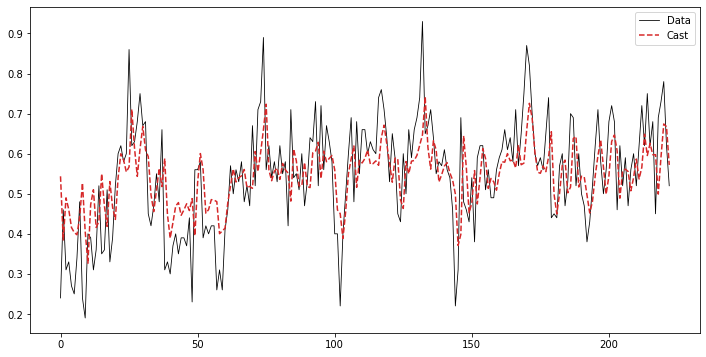


Dataset#	 3
MSE		 7970711.9376002345
all-param	 [-0.50335061 -0.06418349 -0.06032233 -0.01801845]
ar-param	 []
ma-param	 [-0.06418349 -0.06032233 -0.01801845]


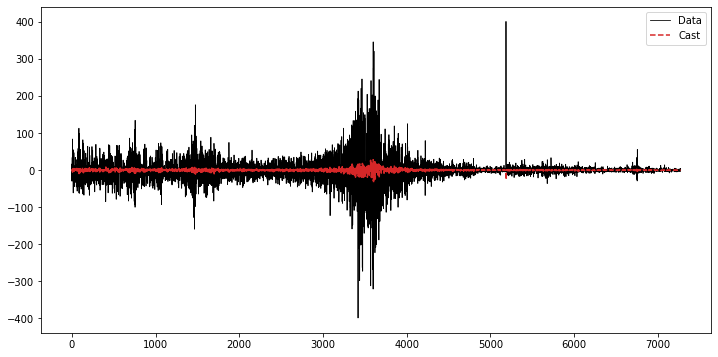


Dataset#	 4
MSE		 962492.408017651
all-param	 [46.12920358  1.64247978  1.50866402  0.70767217]
ar-param	 []
ma-param	 [1.64247978 1.50866402 0.70767217]


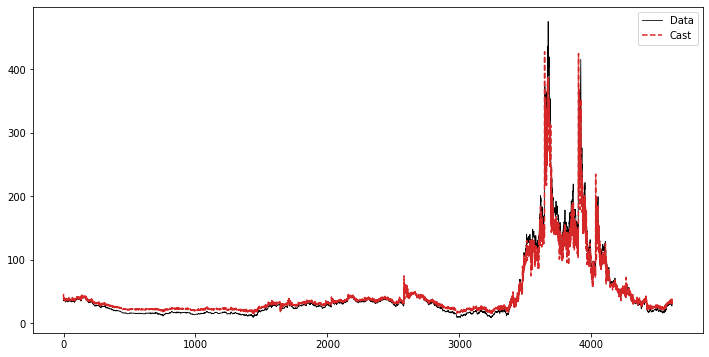


Dataset#	 5
MSE		 118267.00333475672
all-param	 [0.18746041 0.63335538 0.36113389 0.03815068]
ar-param	 []
ma-param	 [0.63335538 0.36113389 0.03815068]


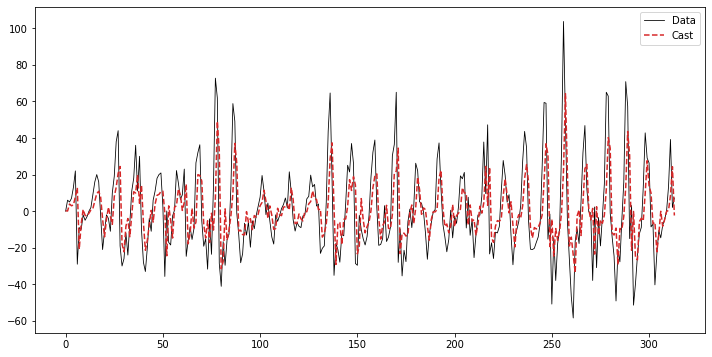


Dataset#	 6
MSE		 224637.0673836242
all-param	 [ 1.90750066  0.03862609  0.12688208 -0.00498423]
ar-param	 []
ma-param	 [ 0.03862609  0.12688208 -0.00498423]


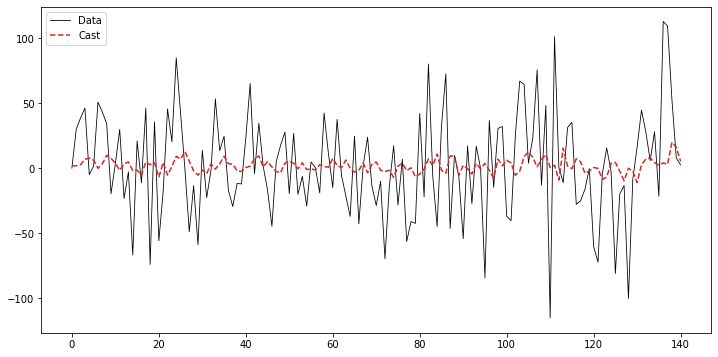

In [ ]:
morder_p =0
morder_q =3
print('Model as ARMA with : ')
print('AR-Order =',morder_p)
print('MA-Order =',morder_q)

for this_ds in range(0, DSnos):
  es_data = DSA[this_ds] # orignal data
  model = tsa.arima_model.ARMA(es_data,order=(morder_p,morder_q))
  result = model.fit(start_params=[0,0,0,0])
  cast = result.predict(  )
  print('\nDataset#\t', this_ds+1)
  print('MSE\t\t',np.sum((es_data-cast)**2) )
  print('all-param\t',result.params)
  print('ar-param\t',result.arparams)
  print('ma-param\t',result.maparams)

  _temp_routine02(es_data,cast,"MR-"+ str(morder_p) + str(result.params), this_ds+1)


### [4] ARIMA

Model as ARMA with : 
AR-Order = 2
MA-Order = 2

Dataset#	 1
MSE		 1.995264419548561
all-param	 [ 0.00895489 -0.21753348  0.06804068 -0.34247441]
ar-param	 [-0.21753348  0.06804068]
ma-param	 [-0.34247441]


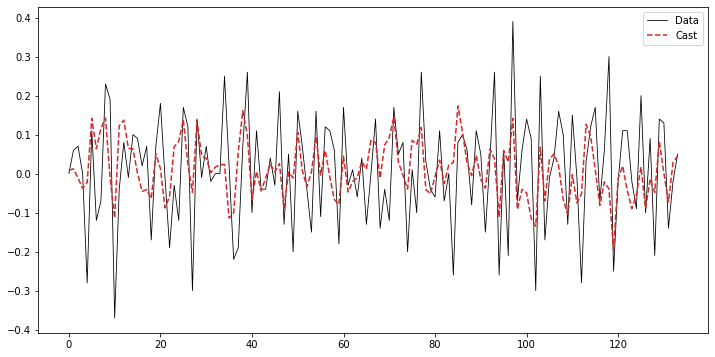


Dataset#	 2
MSE		 2.516812903144623
all-param	 [ 0.54082487  0.5230737   0.26001876 -0.08331207]
ar-param	 [0.5230737  0.26001876]
ma-param	 [-0.08331207]


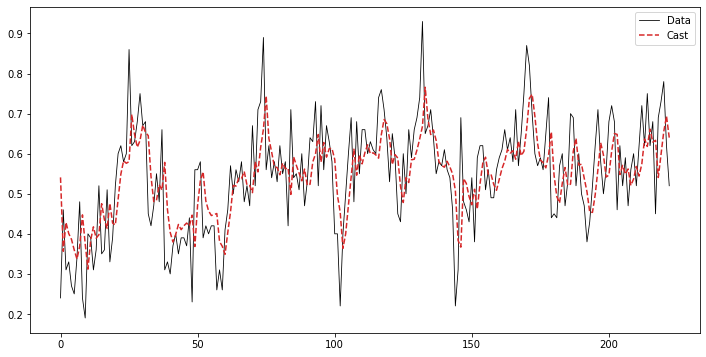


Dataset#	 3
MSE		 7969891.823289301
all-param	 [-0.50350277  0.15691174  0.17308288 -0.22108999]
ar-param	 [0.15691174 0.17308288]
ma-param	 [-0.22108999]


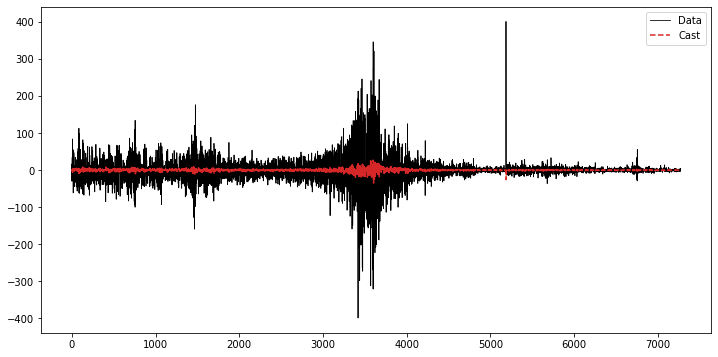


Dataset#	 4
MSE		 156309.47424670242
all-param	 [ 4.53874477e+01  1.02705831e+00 -3.29572195e-02  2.44131022e-02]
ar-param	 [ 1.02705831 -0.03295722]
ma-param	 [0.0244131]


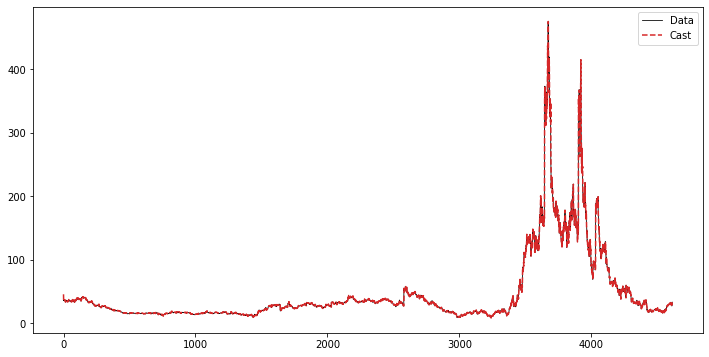


Dataset#	 5
MSE		 117109.9559665704
all-param	 [ 0.18513892  0.36252964 -0.17835696  0.27738175]
ar-param	 [ 0.36252964 -0.17835696]
ma-param	 [0.27738175]


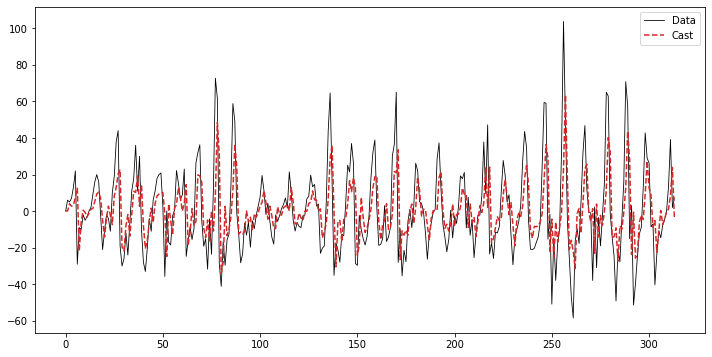


Dataset#	 6
MSE		 224647.62257511378
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


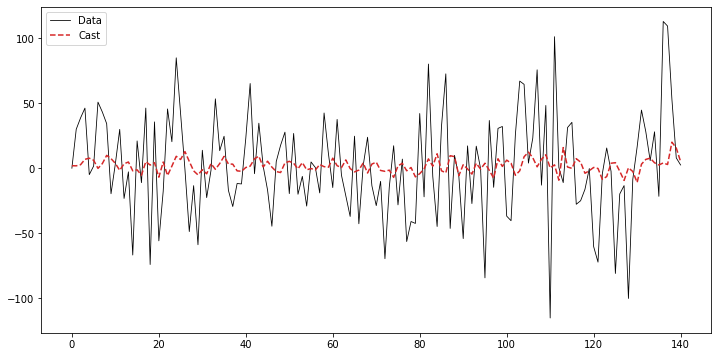

In [ ]:
morder_p =2
morder_q =2
print('Model as ARMA with : ')
print('AR-Order =',morder_p)
print('MA-Order =',morder_q)

for this_ds in range(0, DSnos):
  
  es_data = DSA[this_ds] # orignal data
  model = tsa.arima_model.ARMA(es_data,order=(morder_p,morder_q))
  result = model.fit(start_params=[0,0,0,0])
  cast = result.predict(  )
  print('\nDataset#\t', this_ds+1)
  print('MSE\t\t',np.sum((es_data-cast)**2) )
  print('all-param\t',result.params)
  print('ar-param\t',result.arparams)
  print('ma-param\t',result.maparams)

  _temp_routine02(es_data,cast,"ARMA-"+ str(morder_p) + str(result.params), this_ds+1)


### [4] SARIMA


Dataset#	 1
MSE		 1.60499280287853
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


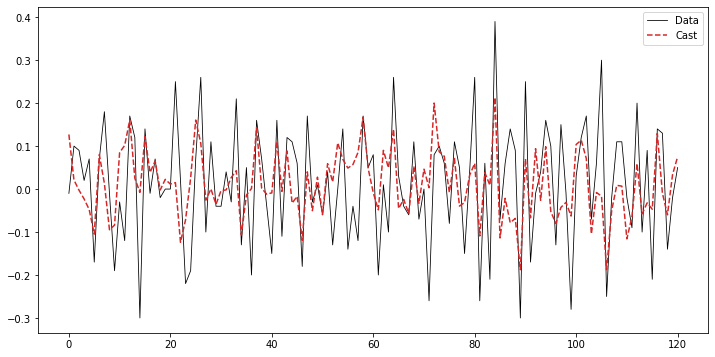


Dataset#	 2
MSE		 2.080913097599404
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


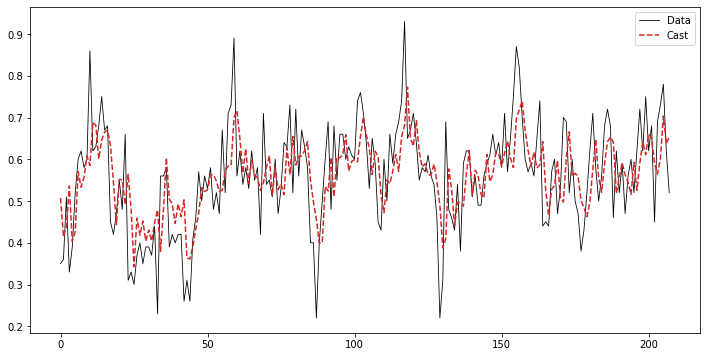


Dataset#	 3
MSE		 7503934.101197399
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


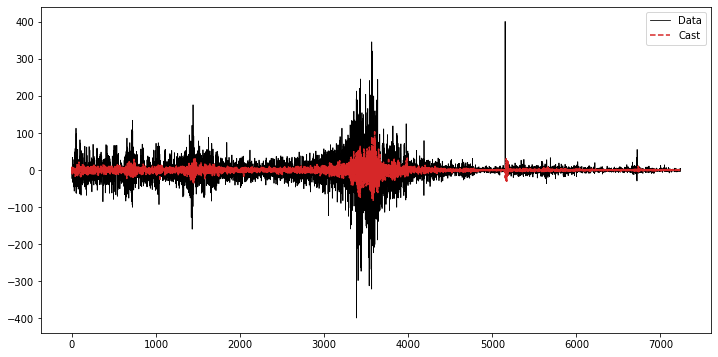


Dataset#	 4
MSE		 144165.51419368878
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


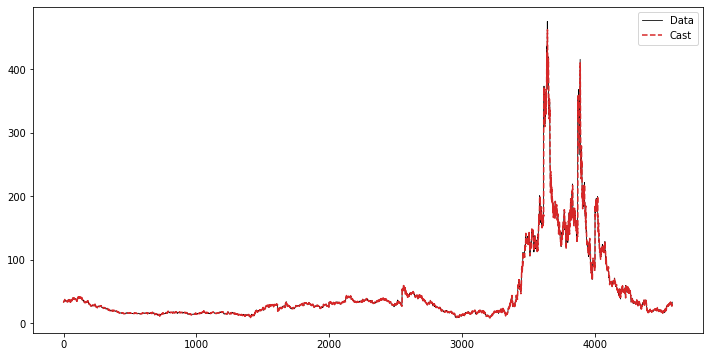


Dataset#	 5
MSE		 67144.48602032554
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


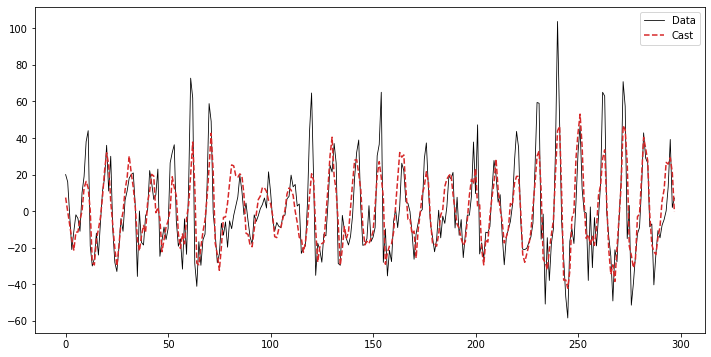


Dataset#	 6
MSE		 200069.61227066795
all-param	 [ 1.90967088 -0.07644001  0.01378661  0.11512299]
ar-param	 [-0.07644001  0.01378661]
ma-param	 [0.11512299]


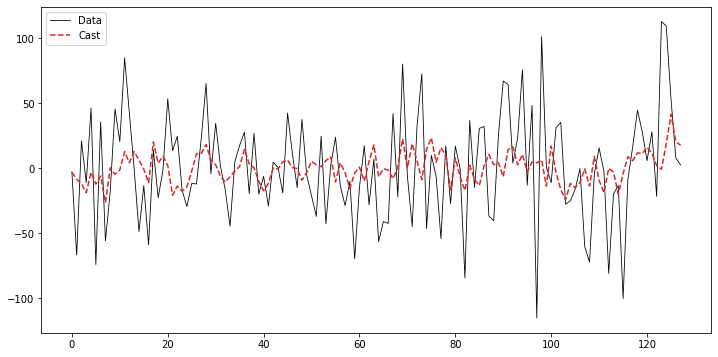

In [ ]:

for this_ds in range(0, DSnos):

  es_data = DSA[this_ds] # orignal data
  cas1 = tsa.arima_model.AR(es_data).fit()
  #print(cas1.params)
  Uc = len(cas1.params)
  cast = cas1.predict(  start=Uc-1 ) 
  print('\nDataset#\t', this_ds+1)
  print('MSE\t\t',np.sum((es_data[Uc-1:]-cast)**2) )
  print('all-param\t',result.params)
  print('ar-param\t',result.arparams)
  print('ma-param\t',result.maparams)

  _temp_routine02(es_data[Uc-1:],cast,"SARMA-"+ str(Uc) + str(cas1.params), this_ds+1,append_result=False)


### View Results

In [ ]:

#print(Result_Ids)
print('')
#print(Result_Tabel)
ds_ids = np.array(DataSet_Ids)

Result_Tabel = np.round(Result_Tabel,3)
print("Showing Result Table Values as MSE, MAE\n")

for d in range(0, DSnos):
  ds_list = np.where(ds_ids==d+1)[0]
  print('\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
  res='\nDATASET:'+str( d+1)+'\t\t'
  
  #res = ''#'Forecast Method \t'
  for j in range(0, len(intervals)):
    res+="Interval="+str(intervals[j])+"\t"
  print(res+'\n')
  for i in ds_list:
    print('=====================================================================================================================================================================')
    print('METHOD: ',Result_Ids[i])
    print('----------------------------------------------------------------------------------------------------------------------------------')
    res = '\tM.S.E\t\t'#Result_Ids[i]+'\t'
    for j in range(0, len(intervals)):
      res+=str(Result_Tabel[i,j,0] )+'\t\t'
    print(res)
    res = '\tM.A.E\t\t'#Result_Ids[i]+'\t'
    for j in range(0, len(intervals)):
      res+=str(Result_Tabel[i,j,1])+'\t\t'
    print(res)
    #print('=======================================================')


Showing Result Table Values as MSE, MAE


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

DATASET:1		Interval=1	Interval=2	Interval=4	Interval=8	Interval=12	Interval=24	

METHOD:  SXS[0.4,_._,_._]
----------------------------------------------------------------------------------------------------------------------------------
	M.S.E		0.002		0.001		0.013		0.012		0.015		0.011		
	M.A.E		0.064		0.045		0.099		0.091		0.094		0.082		
METHOD:  SXS[0.6,_._,_._]
----------------------------------------------------------------------------------------------------------------------------------
	M.S.E		0.001		0.001		0.007		0.006		0.008		0.006		
	M.A.E		0.038		0.03		0.072		0.061		0.069		0.06		
METHOD:  SXS[0.8,_._,_._]
----------------------------------------------------------------------------------------------------------------------------------
	M.S.E		0.0		0.0		0.002		0.002		0.00

### Clear Results

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# CAREFUL - THIS WILL CLEAR ALL PREVIOUS RESULTS

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Result_Tabel = np.zeros((0,len(intervals),2))
Result_Ids = []
DataSet_Ids = []
print("Done!")

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Done!


# [ARCHIVE CODE]

## single ES

Dataset 3
Single Exp Smoothing 
	Try alpha [0.84854517 0.82556881 0.66577401]

Minimum MSE = 46.55637294485313 
	 alpha = 0.8485451693275002 



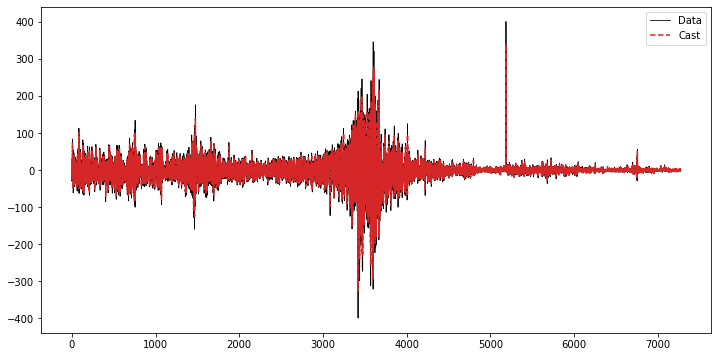

(46.55637294485313,
 array([  0.        , -25.58363686,   9.98197723, ...,   1.86195966,
          0.20563372,   2.26281802]))

In [ ]:
# 1-single exp smoothing
def perform_singleES(es_data, alpha_array):
  print('Single Exp Smoothing','\n\tTry alpha',alpha_array)
  _mse, _cast = [], []
  for alpha in alpha_array:
    mse,cast = es_data.Do_Single_ES(alpha)
    _mse.append(mse)
    _cast.append(cast)

  #  plt.figure(figsize=(12,6))
  #  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  #  plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
  #  plt.legend()


  # plot minimum mse
  mi = np.argmin(_mse)
  print('\nMinimum MSE =',_mse[mi],"\n\t",'alpha =',alpha_array[mi],'\n' )
  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(_cast[mi], linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()
  return _mse[mi], _cast[mi]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#for i in range(0, len(DSA)):
i=2
print('Dataset',i+1)
es_data = ExpSmoothingData(DSA[i]) # orignal data
perform_singleES(
    es_data, 
    np.random.rand(3) 
    )

## double ES


Dataset 3
Double Exp Smoothing 
	Try alpha [0.62458359 0.20111562 0.30288734] 
	Try beta [0.84465503 0.04405168 0.5747295 ]

Minimum MSE: 421.7445231850052 
	 alpha = 0.6245835898020955 
	 beta = 0.8446550349281798 



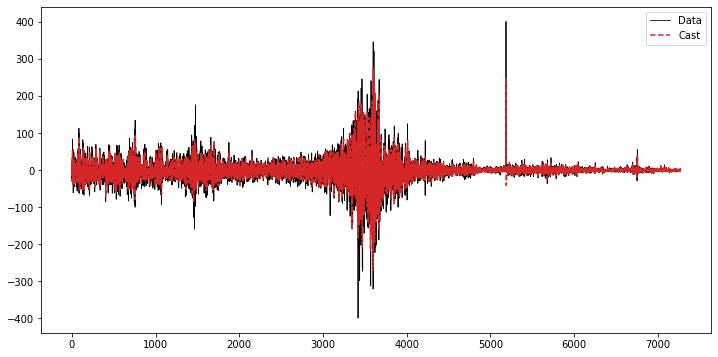

(421.7445231850052,
 array([  0.        , -30.15      , -12.43815951, ...,   3.41393934,
          1.37893118,   1.53887716]))

In [ ]:
# 2-DOUBLE EXP SMOOTHING 

def perform_DoubleES(es_data, alpha_array,beta_array):
  print('Double Exp Smoothing','\n\tTry alpha',alpha_array, '\n\tTry beta',beta_array)
  _mse, _cast = [], []
  for alpha, beta in zip(alpha_array,beta_array):
    mse,cast = es_data.Do_Double_ES(alpha, beta)
    _mse.append(mse)
    _cast.append(cast)

    #plt.figure(figsize=(12,6))
    #plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
    #plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
    #plt.legend()

  # plot minimum mse
  mi = np.argmin(_mse)
  print('\nMinimum MSE:',_mse[mi],"\n\t",'alpha =',alpha_array[mi],'\n\t','beta =',beta_array[mi],'\n' )

  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(_cast[mi], linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()
  return _mse[mi], _cast[mi]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#for i in range(0, len(DSA)):
i=2
print('Dataset',i+1)
es_data = ExpSmoothingData(DSA[i]) # orignal data
perform_DoubleES(
    es_data, 
    np.random.rand(3),
    np.random.rand(3) 
    )

## triple ES

Dataset 3
Triple Exp Smoothing 
	Try alpha [0.85287548 0.03950992 0.30538505] 
	Try beta [0.05725821 0.85876971 0.51058151] 
	Try gamma [0.9559719  0.5460913  0.49461392]

Minimum MSE: 13849.42280445298 
	 alpha = 0.3053850511245526 
	 beta = 0.5105815051807393 
	 gamma = 0.4946139160830333 



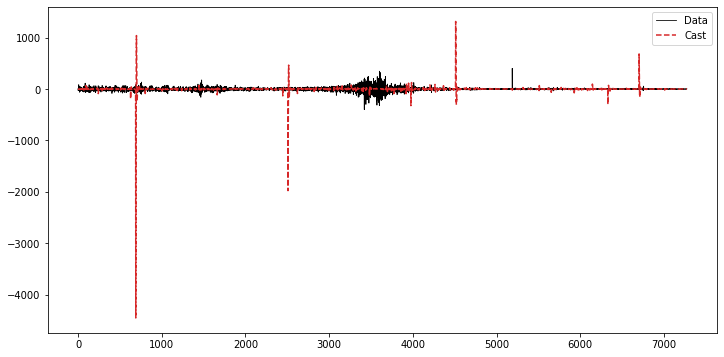

(13849.42280445298,
 array([ 0.        , -3.56517124, -4.0333198 , ...,  1.36394914,
         1.51178028,  1.37014111]))

In [ ]:
# 3-TRIPLE EXP SMOOTHING 

# **** REQUIRES data_LA = for each dataset

def perform_TripleES(es_data, alpha_array,beta_array,gamma_array, data_L):
  print('Triple Exp Smoothing','\n\tTry alpha',alpha_array, '\n\tTry beta',beta_array, '\n\tTry gamma',gamma_array)
  _mse, _cast = [], []
  for alpha, beta, gamma in zip(alpha_array,beta_array,gamma_array):
    mse,cast = es_data.Do_Triple_ES(alpha, beta, gamma, data_L)
    _mse.append(mse)
    _cast.append(cast)

    #plt.figure(figsize=(12,6))
    #plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
    #plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
    #plt.legend()

  # plot minimum mse
  mi = np.argmin(_mse)
  print('\nMinimum MSE:',_mse[mi],"\n\t",'alpha =',alpha_array[mi],'\n\t','beta =',beta_array[mi],'\n\t','gamma =',gamma_array[mi],'\n' )

  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(_cast[mi], linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()
  return _mse[mi], _cast[mi]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#for i in range(0, len(DSA)):
i=2
print('Dataset',i+1)
es_data = ExpSmoothingData(DSA[i]) # orignal data
perform_TripleES(
    es_data, 
    np.random.rand(3),
    np.random.rand(3),
    np.random.rand(3),
    data_LA[i]
    )